In [1]:
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sps
import nlp

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.seq2seq_generator import Seq2Seq, Encoder, Decoder
from src.cnn_discriminator import CNNDiscriminator
from src.utils import *
from src.dataset import Dataset, Padder

import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

sns.set_style('whitegrid')

### 0. Data

In [2]:
dataset_name = 'news'

In [3]:
%%time

if dataset_name == 'cnn':
    train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
    val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
    test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")
    train_articles = [item['article'] for item in train_dataset]
    train_highlights = [item['highlights'] for item in train_dataset]
    val_articles = [item['article'] for item in val_dataset]
    val_highlights = [item['highlights'] for item in val_dataset]
elif dataset_name == 'news':
    news = pd.read_csv('data/news_summary.csv')
    news.headlines = [process_str(s) for s in news.headlines]
    news.text = [process_str(s) for s in news.text]
    X_train, X_test = train_test_split(news, test_size=0.3,
                                       random_state=42)
    train_articles = X_train.text.values
    train_highlights = X_train.headlines.values
    val_articles = X_test.text.values
    val_highlights = X_test.headlines.values

CPU times: user 729 ms, sys: 31.9 ms, total: 761 ms
Wall time: 760 ms


In [4]:
train_new_model = False

In [5]:
%%time
if train_new_model:
    with open('data/news_texts.txt', 'a') as f:
        for article in tqdm(train_articles):
            f.write(article + '\n')
        for highlight in tqdm(train_highlights):
            f.write(highlight + '\n')
        for article in tqdm(val_articles):
            f.write(article + '\n')
        for highlight in tqdm(val_highlights):
            f.write(highlight + '\n')
            
    spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                                   model_prefix='news10k',
                                   vocab_size=10000,
                                   pad_id=0,
                                   bos_id=1,
                                   eos_id=2,
                                   unk_id=3)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.38 µs


### 1. lda

In [6]:
bigram = False
lemmas = False
train_model = False
modelname = f'topic_models/news_train_bigram{bigram}_lemmas{lemmas}.model'

In [7]:
%%time

articles_train_words = process_texts(train_articles, bigram=bigram, lemmas=lemmas)
highlights_train_words = process_texts(train_highlights, bigram=bigram, lemmas=lemmas)

articles_val_words = process_texts(val_articles, bigram=bigram, lemmas=lemmas)
highlights_val_words = process_texts(val_highlights, bigram=bigram, lemmas=lemmas)

id2word = corpora.Dictionary(articles_train_words)

articles_train_corpus = [id2word.doc2bow(text) for text in articles_train_words]
highlights_train_corpus = [id2word.doc2bow(text) for text in highlights_train_words]

articles_val_corpus = [id2word.doc2bow(text) for text in articles_val_words]
highlights_val_corpus = [id2word.doc2bow(text) for text in highlights_val_words]

CPU times: user 26.6 s, sys: 279 ms, total: 26.9 s
Wall time: 26.9 s


In [8]:
%%time
if train_model:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=articles_train_corpus,
                                                id2word=id2word,
                                                num_topics=10, 
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
    lda_model.save(modelname)
else:
    lda_model = gensim.models.ldamodel.LdaModel.load(modelname)

lda_model.print_topics()

CPU times: user 15 ms, sys: 20.1 ms, total: 35 ms
Wall time: 33.8 ms


[(0,
  '0.031*"based" + 0.026*"million" + 0.020*"used" + 0.018*"startup" + 0.014*"using" + 0.013*"deal" + 0.012*"public" + 0.011*"worth" + 0.011*"months" + 0.010*"making"'),
 (1,
  '0.030*"khan" + 0.029*"tweeted" + 0.022*"air" + 0.020*"part" + 0.015*"elections" + 0.015*"shah" + 0.015*"upcoming" + 0.015*"user" + 0.014*"flight" + 0.013*"show"'),
 (2,
  '0.028*"india" + 0.022*"also" + 0.018*"years" + 0.013*"accused" + 0.011*"national" + 0.011*"arrested" + 0.011*"actress" + 0.010*"revealed" + 0.010*"leader" + 0.009*"according"'),
 (3,
  '0.081*"said" + 0.033*"added" + 0.019*"film" + 0.011*"would" + 0.010*"like" + 0.009*"actor" + 0.009*"singh" + 0.008*"people" + 0.007*"wrote" + 0.006*"media"'),
 (4,
  '0.063*"us" + 0.040*"president" + 0.024*"modi" + 0.023*"country" + 0.023*"pm" + 0.021*"trump" + 0.017*"pakistan" + 0.015*"narendra" + 0.013*"donald" + 0.011*"house"'),
 (5,
  '0.024*"china" + 0.022*"security" + 0.019*"car" + 0.015*"series" + 0.015*"led" + 0.015*"states" + 0.014*"away" + 0.014*

In [9]:
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=articles_train_words,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.38893017640073324


### 2. Default metrics

In [10]:
articles_train_topics = [get_topic_vector(lda_model, text) for text in articles_train_corpus]
articles_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in articles_train_corpus]
highlights_train_topics = [get_topic_vector(lda_model, text) for text in highlights_train_corpus]
highlights_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in highlights_train_corpus]

articles_val_topics = [get_topic_vector(lda_model, text) for text in articles_val_corpus]
articles_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in articles_val_corpus]
highlights_val_topics = [get_topic_vector(lda_model, text) for text in highlights_val_corpus]
highlights_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in highlights_val_corpus]

cosines: mean 0.917, std 0.049
euclidean distances: mean 0.16, std 0.051


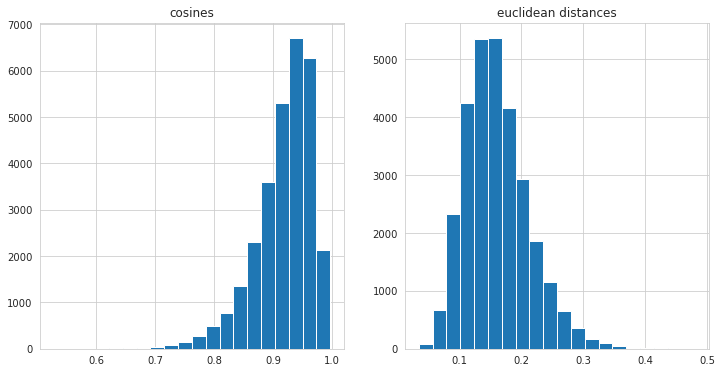

In [11]:
eucl, cosines = plot_distances(articles_val_topics, highlights_val_topics,
                               return_results=True)

In [43]:
# np.save('cosines_default.npy', cosines)
# np.save('eucl_default.npy', eucl)

### 3. Model metrics

In [13]:
vocab_size = 10000
sp_modelname = f'sentencepiece_models/news{int(vocab_size/1000)}k.model'
sp = spm.SentencePieceProcessor(model_file=sp_modelname)

In [14]:
train_dataset = Dataset(train_articles, train_highlights, sp=sp)
val_dataset = Dataset(val_articles, val_highlights, sp=sp)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [106]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/pretrained_seq2seq_gen_2.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [107]:
%%time

predicted_train = []
for i, batch in enumerate(train_dataloader):
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    preds = G.sample(article, highlight, teacher_forcing_ratio=0.)[1]
    predicted_train += tensor_to_text(preds, sp)
    
predicted_val = []
for i, batch in enumerate(val_dataloader):
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    preds = G.sample(article, highlight, teacher_forcing_ratio=0.)[1]
    predicted_val += tensor_to_text(preds, sp)
    
predicted_train_words = process_texts(predicted_train, bigram=bigram, lemmas=lemmas)
predicted_train_corpus = [id2word.doc2bow(text) for text in predicted_train_words]
predicted_train_topics = [get_topic_vector(lda_model, text) for text in predicted_train_corpus]
predicted_train_ohe = [get_ohe_topic_vector(lda_model, text) for text in predicted_train_corpus]

predicted_val_words = process_texts(predicted_val, bigram=bigram, lemmas=lemmas)
predicted_val_corpus = [id2word.doc2bow(text) for text in predicted_val_words]
predicted_val_topics = [get_topic_vector(lda_model, text) for text in predicted_val_corpus]
predicted_val_ohe = [get_ohe_topic_vector(lda_model, text) for text in predicted_val_corpus]

CPU times: user 7min 8s, sys: 29.1 s, total: 7min 37s
Wall time: 1min 17s


cosines: mean 0.878, std 0.071
euclidean distances: mean 0.193, std 0.062


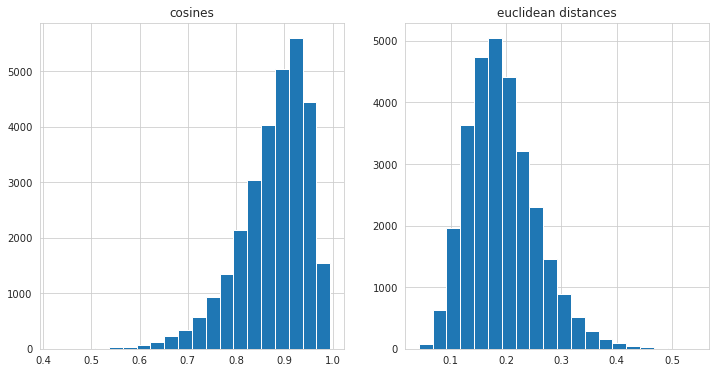

In [109]:
eucl, cosines = plot_distances(articles_val_topics, predicted_val_topics, 
                               return_results=True)

In [92]:
# np.save('preds_gen_topic3_adv.npy', np.array(predicted_val_words))
# np.save('cosines_gen2_adv.npy', cosines)
# np.save('eucl_gen2_adv.npy', eucl)

### 4. Models  metric comparison

In [89]:
def compare_metrics(arr1, arr2, title):
    s, pvalue = sps.mannwhitneyu(arr1, arr2)
    pvalue = np.round(pvalue, 3)
    print(f'pvalue: {pvalue}')

    label1 = f'topic_adv, mean {np.round(np.mean(arr1), 3)}, std {np.round(np.std(arr1), 3)}'
    label2 = f'gen_adv, mean {np.round(np.mean(arr2), 3)}, std {np.round(np.std(arr2), 3)}'

    plt.figure(figsize=(12, 6))

    plt.title('cosines')
    plt.hist(arr1, bins=20, alpha=0.5, density=True, label=label1)
    plt.hist(arr2, bins=20, alpha=0.5, density=True, label=label2) 
    plt.legend()
    plt.show()

In [90]:
cosines1 = np.load('cosines_gen_topic3_adv.npy')
cosines2 = np.load('cosines_gen2_adv.npy')
eucl1 = np.load('eucl_gen_topic3_adv.npy')
eucl2 = np.load('eucl_gen2_adv.npy') 

pvalue: 0.0


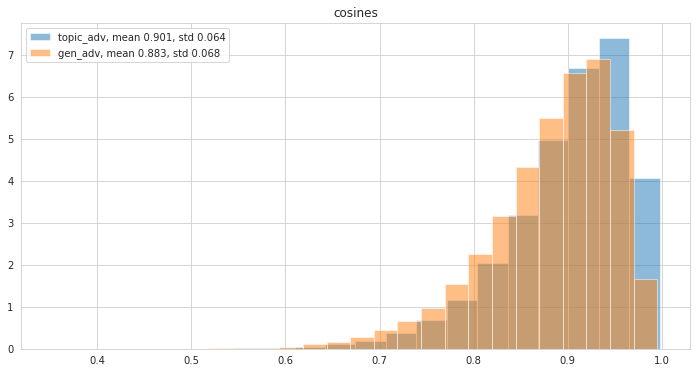

In [91]:
compare_metrics(cosines1, cosines2, 'cosines')

pvalue: 0.0


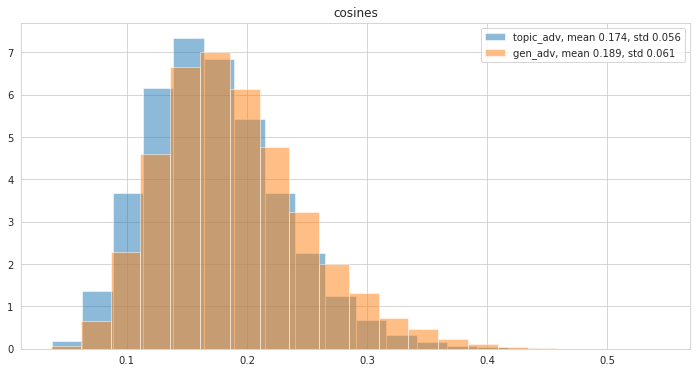

In [81]:
compare_metrics(eucl1, eucl2, 'eucl_dists')

### 5. Models prediction comparison

In [110]:
def preds_to_texts(preds):
    texts = []
    for pred in preds:
        texts.append(' '.join(pred))
        
    return texts

In [118]:
preds1 = np.load('preds_gen_topic3_adv.npy', allow_pickle=True)
preds2 = np.load('preds_gen2_adv.npy', allow_pickle=True)

texts = preds_to_texts(highlights_val_words)
texts1 = preds_to_texts(preds1)
texts2 = preds_to_texts(preds2)
texts3 = preds_to_texts(predicted_val_words)

In [119]:
for text, text1, text2, text3  in zip(texts, texts1, texts2, texts3):
    print(f'       truth: {text}')
    print(f'topic reward: {text1}')
    print(f'  cnn reward: {text2}')
    print(f'   no reward: {text3}')
    print()

       truth: taka students get extra marks parents vote polls
topic reward: bus students add marriage caste parent parent toss cm
  cnn reward: ks student student increase higher even pollss
   no reward: karnataka students marks marksn amount fiveture last polls polls pollss

       truth: syria shoots missiles fired two air bases
topic reward: syrianm mass strikes air missile air missile missile reports trump iran militar
  cnn reward: us removes rocket missile missile units syriarike
   no reward: syrian touristss missiless missile air chemical mergers chinas

       truth: dinosaur like animal fossil found uttarakhand
topic reward: shap laed word inspir surface arunachal assembly report cm cm
  cnn reward: newlylight found dinosaur fossil found foot khand probe
   no reward: found funo mysterious found foot jakhand laga

       truth: may merge shia sunni waqf boards prevent fund wastage
topic reward: prades education board board boards becage kha
  cnn reward: govt plan form diff

  cnn reward: try trump good ambassador us envoy un abbasi
   no reward: honour us country us envoy trump affair trumpi

       truth: rooney left broken nose st goal new team
topic reward: wayneyneneney lefts yard goal childingced
  cnn reward: rooney left left broken nose breaksst fan glove
   no reward: manneyd withoj takes roger injury inch kickss

       truth: isro give students chance launch satellites
topic reward: isro launches diwalis scientist habitg oured
  cnn reward: scientists oxford programmed population accepts
   no reward: worldro levels employee school sectorsrorororo

       truth: russian firm signs bn fertiliser deal indian potash
topic reward: premier citysro mn country hroaingstitra crore
  cnn reward: damra signs buy bn market billion funding
   no reward: sweet winsk approves oil bn ocean dollarn farmers

       truth: saudi arabia return moderate open islam crown prince
topic reward: need revisr reach tr capital crown crownm prince prince saudi
  cnn reward:

  cnn reward: least car warming flu news iraq iraq
   no reward: killed ironed terror ated innsi

       truth: irs officer sanjay mishra takes charge interim ed chief
topic reward: awarda theal postings ed oscar story film
  cnn reward: bhartia kumara architect ya nameded roy hea directored
   no reward: whof jains chairman ofed ededed edsing mallya

       truth: melinda stops talking toilets dinner gates
topic reward: would tell thes stops jacque toilet condoms
  cnn reward: leave harassing toilets toilet carding first reieie
   no reward: would would cut toilets delhi bill

       truth: wto favours china unfair us trump
topic reward: ready us trade secret partner prove trumpst tradech trump usz trump trump trump respect trump
  cnn reward: donald us internalisation ended due us us trump trump
   no reward: trump sed us secret trump us us trump pre

       truth: jetprivilege helps find best hotel deals
topic reward: jet mumbai hotel let suit widow book made hotel hotel hotels blas

topic reward: ex slam employee employeees exec miruss tech cfo employee
  cnn reward: former startup ex workercompany secretpiments santas
   no reward: former startup startupcompany firm chain hiss graves us santaed

       truth: sehwag hit ton batting number st test innings
topic reward: sehwagwags maiden lunch ing ball odi odi
  cnn reward: sehwag takes batsman ton testn dur hisashes sies
   no reward: sehwagwagwag first test fews inn atin

       truth: good times pack bags italy illegal migrants
topic reward: shoulding rightss besed pick union union union minister argu
  cnn reward: em make name union minister voters
   no reward: could buils onfrom scare vote khalf politic

       truth: virat male female versions anushka
topic reward: makes see tiwar anushka kohl respect odi odi odi
  cnn reward: see two marriages us anushka anushka
   no reward: hit wonder ton us cricket gambhir single select virat anushka virat

       truth: pakistan pm put security check us airport
topic re

  cnn reward: wepti may see increasing weak generation says report india china
   no reward: india avoid fmonas gst niti niti chairman

       truth: nukes would cause unacceptable damage enemy russia
topic reward: europe ensure ae iran claimy chief us
  cnn reward: us europenuclear program inevitable toing emergency
   no reward: program strong ex us politician chief chief

       truth: dead crore trees uprooted italy apocalyptic storm
topic reward: earths killcross killam runsr bangladesh building powery heavy rains
  cnn reward: accused kill ed month crore italy yearsy factory
   no reward: heavy rise ins dies securityycan

       truth: indian space telescope measures star parameters taurus
topic reward: spacecraft reachesst earthus craft warrior carrystn space space space
  cnn reward: worldses supercomputer collisioned aircst plan detect craft rayium
   no reward: india joinsji fly pr flying flys flyfrom plan

       truth: rohit fastest cricketer smash sixes odi cricket history

  cnn reward: britain pay bn pay leave brexit deal
   no reward: britain see utilis pays crore israel brexland deal brex years

       truth: jammu kashmir soon join gst regime jaitley
topic reward: jammu wip day forms service services minister jaitley
  cnn reward: ju kashmir join good news jaitleys arun jaitley
   no reward: warn join good narendra jaitley jaitley jaitleyic

       truth: raj cops refuse give guard honour rajnath singh
topic reward: raj parent backs give searchs raj singh given story story
  cnn reward: rajasthan copa refuse give guard full one cm officer
   no reward: police asked suspend farmers whoed donate singh opted nrc days

       truth: lic gets notice paying crore service tax
topic reward: govt clearss crore nov two cr role tax firm yst scanner
  cnn reward: rcom proposal toes pay financial fee business concern
   no reward: india approves fee files financialed firms julyed fraud body

       truth: microsoft tops reuters top global tech leaders list
topic 

  cnn reward: texas districts elected tableuriering replica
   no reward: texas boy mp stationuing parting double schools

       truth: number indian potential victims slavery uk rises
topic reward: indian traffick landmark traffick drunk uk iny woman
  cnn reward: citizens traffick fell cases doubled uk may freed
   no reward: govts detentionedfrom attack trafficks began british uk uk men doubled uk

       truth: records turnout th phase panchayat polls
topic reward: home record recordout voter indias polls khead
  cnn reward: records turnout clear phase party polls
   no reward: formingout turnoutout th roads phase bo seat

       truth: jadhav mother visa letter even acknowledged sushma
topic reward: pak even judge fored letter india lies visajadhav name swaraj
  cnn reward: one team allowed suggestion suggestion visa jadhav
   no reward: pakistan letter lettering martyrd swa swa

       truth: scientists find evidence britain separation europe
topic reward: uk remove led dwarf se

   no reward: govt constitutess mays managements maha

       truth: group thrashed trying hoist tricolour srinagar
topic reward: youth india flag flaged protect jamm kashmir blastsed blast cm blast
  cnn reward: civilians killed indian flag terror jammu
   no reward: jawan men tricolour ins along himachalu elephantsu

       truth: robotic crawling baby helps study dust affects babies
topic reward: makings production cell gett dual study study studyball study story
  cnn reward: chunkus coipsst dies us research study made
   no reward: tilt building fill four faster four light bottle spread studyssh

       truth: one beat yuvraj comes farting harbhajan
topic reward: pandya one hit along wicket harbhajan harbhajan ona odi odi
  cnn reward: one base tell yuv yuvraj sledging notes
   no reward: one sensen champ sachin yuvam live harbhajan sharma

       truth: jessica murder convict moved open jail good conduct
topic reward: kerala court sentenced jail sex jail due prisons case case bla

   no reward: trump trump helps card art mac europe

       truth: aiadmk merger betrayal sasikala dhinakaran
topic reward: dhin dalit long kumar ofiadiadiadmk dhin resultiadsy cm
  cnn reward: dhinakaran chiefss naduiad securitiadala dhinakaran
   no reward: secmkiadiadmkss aiadmkmk aiadmk siads asiad

       truth: kerala tourism min denied permission attend meet china
topic reward: india denie denys serving resolution touris touris tourism sahib govt cm cm
  cnn reward: dids boycott unty co post leaderm
   no reward: centre denies refuting kerala cabinet area unm tibet india report

       truth: year old female indigo employee found hanging guest house
topic reward: fake man uperer found found headfrom womangram gurugram blast woman
  cnn reward: woman youtuber founds ladder found ins arrested
   no reward: man woman managed woman found ined diwalis

       truth: felt ashamed filming sex scenes big little lies nicole
topic reward: actress beautiful comple elld singer scene scene f

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  cnn reward: sushil make national near enter boxer open
   no reward: sushil make skip squad worlds

       truth: singer wears rubik cube inspired dress billboard awards
topic reward: de doesstee share memess money award zes new award money
  cnn reward: singerncieee sss engagement golden
   no reward: zaynasee lipstick lipstick ss frees billboards

       truth: apple removes skype app store china
topic reward: apple removes service app map apple earth apple change story remove
  cnn reward: apple removes microsoft apppe reading store chinay
   no reward: apple removes anothersoft old going website store chinape

       truth: inter caste marriage reduce attacks dalits union min
topic reward: relation reservation cmssys quota minister ministergiri cm cm
  cnn reward: names gives marriage caste marriages union minister
   no reward: proposal give inter threatss talaq union chief

       truth: north korea ballistic missile test launch fails
topic reward: north korea tests test testst

topic reward: kfci jail goed tos jail fored muslim kidnapping blast cfo cfo
  cnn reward: china arrestsedhed jails crime killing killing
   no reward: kalk womanedfrom indian yr jail murder jail yr yearsspur

       truth: delhi govt warns action liquor served
topic reward: customs legalsss legal legals delhi govt hc hc
  cnn reward: delhi warnss delivery visentss
   no reward: delhi waives shops shops ats bars ins govts madrass

       truth: got problems jon snow game thrones actress
topic reward: got hate guy jacque snow uncleeoing credit sanyagar
  cnn reward: got favourite snow injur reads snow nete poem
   no reward: lowsy students fans ariana withlan forsyai

       truth: man makes lewd gesture woman later finds cop
topic reward: burglar man detain delhi airportedb fakeaughtr delhi blast blast blast woman
  cnn reward: mann delhi delhi jawan handle women check delhi
   no reward: man sneakss ship shout women arrested delhi delhi

       truth: yr old steals mom new bmw meet gir

topic reward: swa sed ed find killer mother killer turns son accident army woman blast woman
  cnn reward: self proof survivors dhther told dead survivor police
   no reward: amarnath helplineles kill artss nails cars

       truth: delhi police collaborates uber women safety
topic reward: uber updates coping asks cab riders cab cabtys memo google woman fb woman
  cnn reward: ubers police womenisf identify safe safetyty police
   no reward: uber police delhi women safety centre woment womens

       truth: teaser nawazuddin starrer biopic bal thackeray
topic reward: teaser roshan thackerayayay nawaz nawazi story story story story dutt
  cnn reward: teaser jaya thacker balayay
   no reward: teaser taapse balk tay raut padmavat padmavatiaosed

       truth: us weed firm buys town cr weed friendly tourism
topic reward: american booking products buy million crore market tech tech
  cnn reward: hacker maker maker boe proposal bid sick crore
   no reward: marij marijm mn crore worth crore cr

topic reward: uk doctorss newst beach drug drugtyg uses
  cnn reward: first first ever cure may offerak counter drug grow doctors
   no reward: uk doctor thev superst pre first blackine inesical

       truth: aamir told fatima films year sanya
topic reward: justamir khan boy nas within films johars
  cnn reward: aamir khan called ar films sanya sanya sanya
   no reward: aamir aamir defeat ghat go become basu grant sanya sanya

       truth: mystery satoshi nakamoto puzzle solved yrs
topic reward: bitcoin suedes buffetedt permit bitcoin bitcoin valu years money
  cnn reward: artist cockroached bitcoining bitcoin lakh exchange worth years ago
   no reward: hello yeared offersed transform forssseds

       truth: rekha performs iifa award ceremony years
topic reward: actress perform perform indianifa award award award speech story film
  cnn reward: rekha perform perform filmy iifa awards best awards
   no reward: hero perform forn movement ceremonssssss

       truth: bengaluru accommod

  cnn reward: cbi delay ban bann banned decik tosafe since aprilfrom
   no reward: mumbaikata pubsss used yr jan jan

       truth: syrian teen wins children peace prize building school
topic reward: born since captain lawishn peace prisoners refugee
  cnn reward: test oldor veteran winss children korean tribal us
   no reward: veteraneds tochildren nobel lead familie syrian law

       truth: man included citizen list declared foreigner
topic reward: man declarees probive passport list government list cr nrc majorits
  cnn reward: australia man declared st detail detected assam nrc
   no reward: man man man forced reported commission local nrcary nrc gets

       truth: us review pakistan bailout request imf
topic reward: us issue pakistan status foryit lowerit us
  cnn reward: us threatens pakistan visa imfth imf prices
   no reward: pakistan say issue pak absolute approval imfd imf envoy

       truth: cong shares pm itinerary breakfast lunch fast day
topic reward: condemnify itatio

  cnn reward: people killed bus collapse collapse amid noida roads
   no reward: deaded injur wb bus collapseed noida noida

       truth: rcb end ipl bottom points table despite win dd
topic reward: jumps si starts kohli run despi bigge asi strike season odi
  cnn reward: rcb bdars register help kohli sts
   no reward: rcb beats yr atiar kares aties win

       truth: online pharmacy startup lifcare gets mn saif others
topic reward: delhi bas gapp platformed eline bas startup raise mn million million valuation venture valuation
  cnn reward: indianline bas sales fory startup million mn funds
   no reward: thin store celllesscomm based delivery startup fund

       truth: delhi per capita income three times national average survey
topic reward: identifis population indally new kher ministr
  cnn reward: ing greened toed govt destination days
   no reward: govt mandate st printed national scrap program study

       truth: suicide attack nato convoy injures afghanistan
topic reward: kil

   no reward: bjp presidents hasss pm modi remark pm rain ganas

       truth: bid exempt grandparents us travel ban rejected
topic reward: us judge rejected suspend could ban bans trump
  cnn reward: us challenges heads carriers trump bans
   no reward: us judge judge judgess decisions stay traffic issuesing

       truth: feel helpless harsh rampal salman conviction
topic reward: feel give helplessless change kat life rahimst
  cnn reward: helpated touched anushkasalman baning
   no reward: hard drug even death priyanka tomb tweets jodh crimece

       truth: anupam kher accidental prime minister hits theatres
topic reward: irani film smriti thess hitss theatres theatres
  cnn reward: kher kher gets avengers dear theatre hits theatres
   no reward: anupam shin dev hitsss thess theatres

       truth: mumbai firm sues amazon non payment rental dues
topic reward: amazon sued amazonac based stor inedac wallet
  cnn reward: amazon sued operating bengalur executives sponsor grocers
   no 

   no reward: passenger bodys door says food food cars service

       truth: bumrah scores first international run th match
topic reward: india player hit scoresth inth england matches run match odi odi odi
  cnn reward: odi scor scores scorst int matches ttrophytrophy
   no reward: batsman sets debut cricket ths match

       truth: german man alleges molestation ghaziabad hotel employee
topic reward: wound yr ex man man molesting cop molest trad rashu victim case blast
  cnn reward: man held manager serving hotel hotel accus hotel molest molest cops probe
   no reward: man claims tea doctored offer hotel protest ex suicide

       truth: russia funding taliban anti nato operations reports
topic reward: russia supply commits plan us ss facilit reports trump iran plans
  cnn reward: russia nations supplying afghanistan
   no reward: russia seeks oil flees head route reports

       truth: anil kapoor reveals dated girls film industry
topic reward: haveed girlfrom anil anill story
  cn

   no reward: wanted hereded shaped bose inspired ownerar

       truth: nd accused chandigarh stalking case
topic reward: son removed yadav killing stalking case haryana
  cnn reward: sp kumar son accused jeegarh stalking stalk case
   no reward: leader son kumar stabbed admitted ambeitygarhwara haryanaiked

       truth: meru cabs predatory pricing complaint ola rejected
topic reward: cci prompted predatorsst sale taxi permit hoteling cci cci cfo
  cnn reward: error denie predatorsst taxi ai close law manager fraud
   no reward: payssed accusing uk banned clear auto system

       truth: india touch veto issue wants un sc seat us
topic reward: country today brita want wars bid trump
  cnn reward: un canno nation us envoy unsc military
   no reward: giving would india director united un un antigua

       truth: cia chief formed good relationship kim jong un trump
topic reward: report met former jongies president trump
  cnn reward: us media chief trump good good meeting us us prez tr